# FIFA
This model is in progress...

## Description
This is a simple feed forward network for fifa dataset
    https://www.kaggle.com/karangadiya/fifa19

# Imports

In [6]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from models.mlp import FeedForwardNetwork
from utils.loading import Loader
from utils.trainer import Trainer

tf.enable_eager_execution()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Constants

In [2]:
EPOCHS = 20
LEARNING_RATE = 0.001
BATCH_SIZE = 64
TRAIN_FRACTION = 0.8
WEIGHT_DECAY = 0.02
DROPOUT = 0.1

# Preprocess data

In [3]:
def height_conversion(feet_and_inches):
    feet, inches = feet_and_inches.split("'")
    return float(feet) * 30.48 + float(inches) * 2.54

def weight_conversion(lbs):
    lbs = lbs[:-3]
    lbs = float(lbs)
    return lbs * 0.45359237

In [18]:
loader = Loader('datasets/fifa.csv')
features = ['Age', 'Height', 'Weight']
target_feature = 'Agility'
loader.set_features(features + [target_feature])
loader.apply('Height', height_conversion)
loader.apply('Weight', weight_conversion)

# Explore data

   Age  Height     Weight  Agility
0   31  170.18  72.121187     91.0
1   33  187.96  83.007404     87.0
2   26  175.26  68.038855     96.0
3   27  193.04  76.203518     60.0
4   27  180.34  69.853225     79.0


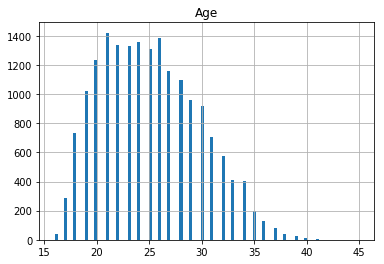

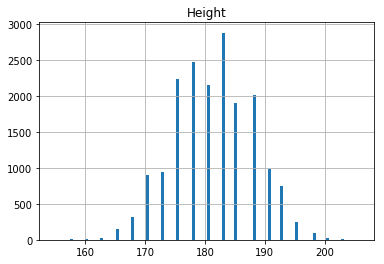

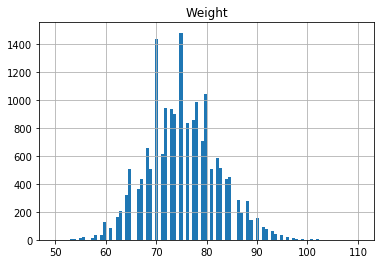

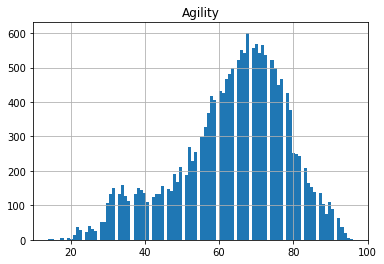

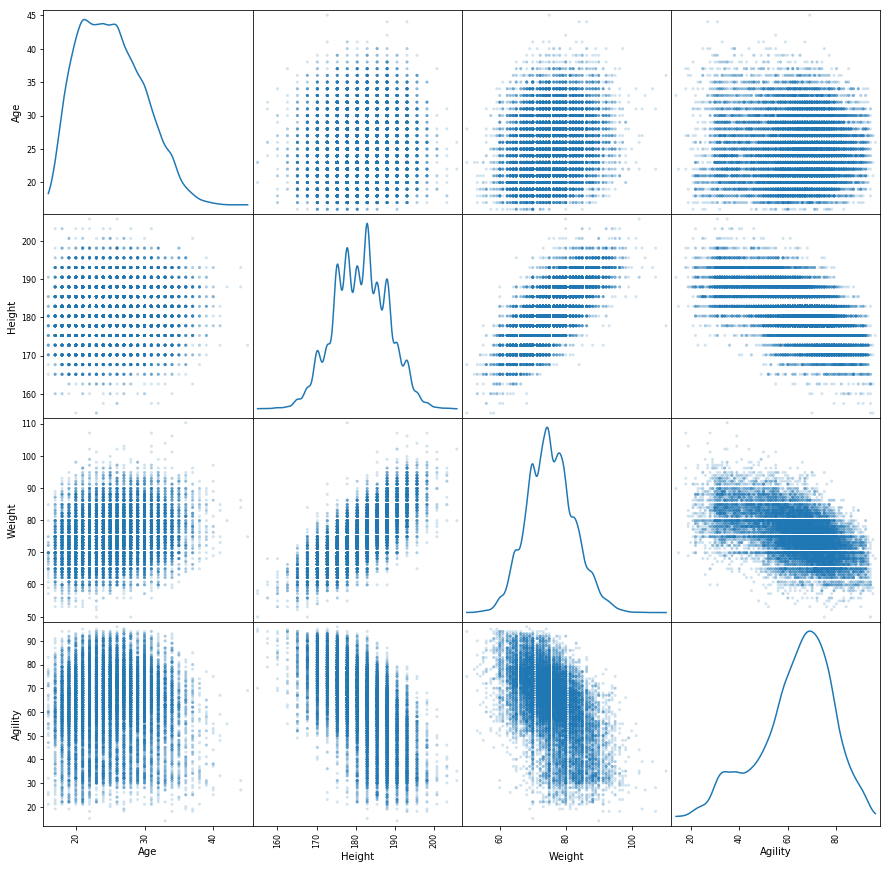

In [19]:
data = loader.get_data()
print(data.head())
for f in features + [target_feature]:
    data.hist(column=f, bins=100)
from pandas.plotting import scatter_matrix
scatter_matrix(data, alpha=0.2, figsize=(15, 15), diagonal='kde');

# Train model

In [8]:
def compute_accuracy(logits, targets):
    losses = tf.losses.mean_squared_error(targets, logits)
    return tf.reduce_mean(losses)

def compute_loss(targets, logits):
    losses = tf.losses.huber_loss(targets, logits)
    loss_value = tf.reduce_mean(losses)
    return loss_value

In [43]:
EPOCHS = 20
LEARNING_RATE = 0.001
BATCH_SIZE = 64
TRAIN_FRACTION = 0.8

# Create data split
train_data, test_data = loader.get_data_split(TRAIN_FRACTION, target_name='Agility')

# Create model and optimizer
model = FeedForwardNetwork(units=[32, 32], use_sigmoid=False)
optimizer = tf.train.RMSPropOptimizer(learning_rate=LEARNING_RATE)

# Train
trainer = Trainer(model, optimizer, train_data, test_data, compute_loss, compute_accuracy)
train_losses, train_accs, test_losses, test_accs = trainer.train(EPOCHS, BATCH_SIZE)

Epoch 01 - Train[Loss=56.877, Metric=3545.738], Test[Loss=42.145, Metric=2078.034]
Epoch 02 - Train[Loss=24.504, Metric=894.378], Test[Loss=16.225, Metric=417.504]
Epoch 03 - Train[Loss=13.067, Metric=289.132], Test[Loss=10.610, Metric=199.632]
Epoch 04 - Train[Loss=9.518, Metric=165.623], Test[Loss=8.899, Metric=145.332]
Epoch 05 - Train[Loss=8.721, Metric=141.751], Test[Loss=8.599, Metric=137.033]
Epoch 06 - Train[Loss=8.571, Metric=137.460], Test[Loss=8.519, Metric=134.691]
Epoch 07 - Train[Loss=8.527, Metric=136.160], Test[Loss=8.486, Metric=133.704]
Epoch 08 - Train[Loss=8.511, Metric=135.665], Test[Loss=8.472, Metric=133.310]
Epoch 09 - Train[Loss=8.503, Metric=135.437], Test[Loss=8.464, Metric=133.120]
Epoch 10 - Train[Loss=8.498, Metric=135.305], Test[Loss=8.458, Metric=133.002]
Epoch 11 - Train[Loss=8.495, Metric=135.223], Test[Loss=8.455, Metric=132.926]
Epoch 12 - Train[Loss=8.493, Metric=135.171], Test[Loss=8.453, Metric=132.871]
Epoch 13 - Train[Loss=8.492, Metric=135.134]

In [35]:
# Try a few
iterator = test_data.make_one_shot_iterator()
for i, (inputs, label) in enumerate(iterator):
    inputs = tf.reshape(inputs, (1, *inputs.shape))
    pred = model(inputs, training=False)
    pred = tf.contrib.layers.flatten(pred)[0,0]
    print("Prediction: {:.3f}, Label: {:.3f}".format(pred, label[0]))
    if i > 10:
        break

Prediction: 50.922, Label: 60.000
Prediction: 76.174, Label: 95.000
Prediction: 55.262, Label: 58.000
Prediction: 74.235, Label: 90.000
Prediction: 52.952, Label: 37.000
Prediction: 78.056, Label: 86.000
Prediction: 53.446, Label: 55.000
Prediction: 41.650, Label: 47.000
Prediction: 69.042, Label: 76.000
Prediction: 57.937, Label: 60.000
Prediction: 79.640, Label: 90.000
Prediction: 82.038, Label: 87.000


# Plot results

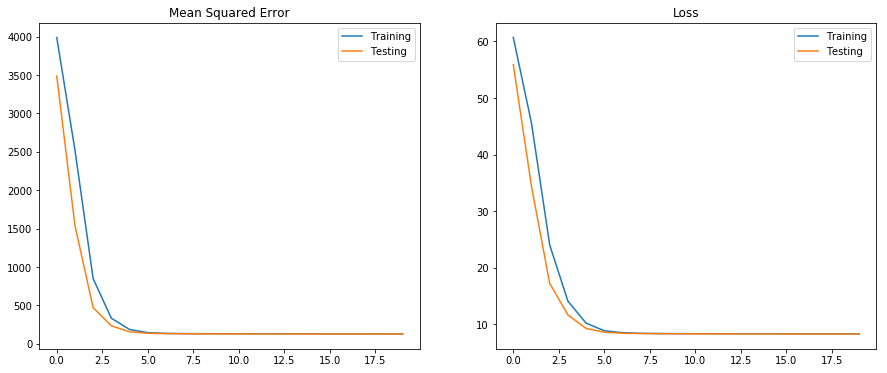

In [40]:
_, (ax1, ax2) = plt.subplots(figsize=(15, 6), nrows=1, ncols=2)
ax1.plot(train_accs)
ax1.plot(test_accs)
ax1.set_title("Mean Squared Error")
ax1.legend(['Training', 'Testing'])
ax2.plot(train_losses)
ax2.plot(test_losses)
ax2.set_title("Loss")
ax2.legend(['Training', 'Testing'])
plt.show()